In [5]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

Load Data

In [6]:
tv = TvDatafeed()
df = tv.get_hist(symbol='SET:SET50', exchange='SET', interval=Interval.in_daily, n_bars=1201)
set50 = df[['close']]
set50.rename(columns = {'close':'set50'}, inplace=True)
set50

C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_26752\1210163760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set50.rename(columns = {'close':'set50'}, inplace=True)


,set50
datetime,
2019-05-17 09:00:00,1068.45000
2019-05-21 09:00:00,1071.60000
2019-05-22 09:00:00,1083.04000
2019-05-23 09:00:00,1070.49000
2019-05-24 09:00:00,1072.13000
...,...
2024-04-23 09:00:00,832.20001
2024-04-24 09:00:00,834.73999
2024-04-25 09:00:00,836.54999


In [7]:
name = ['SET:ADVANC', 'SET:AOT', 'SET:AWC', 'SET:BANPU', 'SET:BBL', 'SET:BDMS', 'SET:BEM', 'SET:BGRIM', 'SET:BH', 'SET:BTS', 'SET:CBG', 'SET:CENTEL', 'SET:COM7', 'SET:CPALL', 'SET:CPF', 'SET:CPN', 'SET:CRC', 'SET:DELTA', 'SET:EA', 'SET:EGCO', 'SET:GLOBAL', 'SET:GPSC', 'SET:GULF', 'SET:HMPRO', 'SET:INTUCH', 'SET:IVL', 'SET:KBANK', 'SET:KCE', 'SET:KTB', 'SET:KTC', 'SET:LH', 'SET:MINT', 'SET:MTC', 'SET:OR', 'SET:OSP', 'SET:PTT', 'SET:PTTEP', 'SET:PTTGC', 'SET:RATCH', 'SET:SAWAD', 'SET:SCB', 'SET:SCC', 'SET:SCGP', 'SET:TISCO', 'SET:TOP', 'SET:TRUE', 'SET:TTB', 'SET:TU', 'SET:WHA', 'SET:TLI']

#load all set50 data
for i in range (len(name)):
    df = tv.get_hist(symbol=name[i], exchange='SET', interval=Interval.in_daily, n_bars=1201)
    df = df[['close']]
    set50 = pd.merge(set50, df, left_index=True, right_index=True, how='outer')
    set50.rename(columns = {'close':name[i]}, inplace=True)
set50 = set50.drop('set50',axis=1)

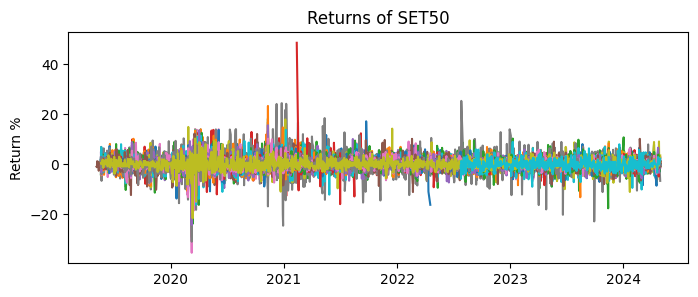

In [8]:
returns = np.log(set50).diff() * 100 #1st difference
plt.figure(figsize=(8,3))
plt.plot(returns)
plt.ylabel("Return %")
plt.title('Returns of SET50');

Loop for the best model in each Stock

In [9]:
conclu = pd.DataFrame(name, columns=['SET50'])

In [10]:
from arch import arch_model
from sklearn.metrics import mean_squared_error
best_model_list = []
for i in range (len(name)):

    returns_individual = returns[[name[i]]]
    returns_individual = returns_individual.dropna()

    real_vol = []
    for i in range(len(returns)):
        vol = returns_individual[:i].std()
        real_vol.append(vol)

    len_test = int(0.2 * len(returns_individual))
    test_vol = real_vol[-len_test:]

    returns_train, returns_test= returns_individual[:-len_test], returns_individual[-len_test:]

    garch_model_fit = arch_model(returns_train,vol="Garch",p=1,q=1).fit(disp='off',update_freq=len(returns_test))
    arch_model_fit = arch_model(returns_train,vol="ARCH").fit(disp='off',update_freq=len(returns_test))
    gjr_garch_model_fit = arch_model(returns_train,p=1,o=1,q=1).fit(disp='off',update_freq=len(returns_test))
    harch_model_fit = arch_model(returns_train,vol='Harch').fit(disp='off',update_freq=len(returns_test))

    garch_forecast = garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    arch_forecast = arch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    gjr_garch_forecast = gjr_garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    harch_forecast = harch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)

    garch = garch_forecast.variance.values[-1,:].flatten()
    arch = arch_forecast.variance.values[-1,:].flatten()
    gjr = gjr_garch_forecast.variance.values[-1,:].flatten()
    harch = harch_forecast.variance.values[-1,:].flatten()

    df_test = returns_test.copy()
    df_test['garch']= np.sqrt(garch)
    df_test['arch']= np.sqrt(arch)
    df_test['gjr']= np.sqrt(gjr)
    df_test['harch']= np.sqrt(harch)
    df_test['Vol'] = np.array(test_vol)

    garch_mae = mean_squared_error(df_test['Vol'],df_test['garch'])
    arch_mae = mean_squared_error(df_test['Vol'],df_test['arch'])
    gjr_garch_mae = mean_squared_error(df_test['Vol'],df_test['gjr'])
    harch_mae = mean_squared_error(df_test['Vol'],df_test['harch'])
    mae = [garch_mae,arch_mae,gjr_garch_mae,harch_mae]
    best = mae.index(min(mae))

    if best == 0:
        mod = 'garch'
    elif best == 1:
        mod = 'arch'
    elif best == 2:
        mod = 'gjr'
    elif best == 3:
        mod = 'harch'
    best_model_list.append(mod)

conclu['Models'] = np.array(best_model_list)

Fit entire dataset with the best model of each stock

In [11]:
volatility_list = []
for i in range (len(name)):
    returns_individual = returns[[name[i]]].dropna()
    if conclu['Models'][i] == 'garch':
        forecast_model_fit = arch_model(returns_individual,vol="Garch", p=1,q=1).fit(disp='off')
    elif conclu['Models'][i] == 'arch':
        forecast_model_fit = arch_model(returns_individual,vol="ARCH").fit(disp='off')
    elif conclu['Models'][i] == 'gjr':
        forecast_model_fit = arch_model(returns_individual,p=1,o=1,q=1).fit(disp='off')
    elif conclu['Models'][i] == 'harch':
        forecast_model_fit = arch_model(returns_individual,vol="Harch").fit(disp='off')
    forecaste = forecast_model_fit.forecast(horizon=120,method='analytic',reindex=True)
    y = forecaste.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(252)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list.append(vol6m)
conclu['Vol'] = np.array(volatility_list)

C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_26752\2245444320.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['forecast'].tail(1))
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_26752\2245444320.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['forecast'].tail(1))
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_26752\2245444320.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['forecast'].tail(1))
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_26752\2245444320.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['

In [12]:
conclu

,SET50,Models,Vol
0,SET:ADVANC,arch,20.933604
1,SET:AOT,harch,32.363741
2,SET:AWC,harch,42.302363
3,SET:BANPU,harch,44.299585
4,SET:BBL,arch,27.877941
5,SET:BDMS,harch,24.946446
6,SET:BEM,arch,25.235027
7,SET:BGRIM,arch,35.686303
8,SET:BH,arch,30.251552
9,SET:BTS,garch,28.684612
